In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver
    
%load_ext autoreload
%autoreload 2

In [2]:
# uncomment if required to use default network
# from network import Network

class Network(object):
    def __init__(self):
        self.layers = None
        self.create_layers()

    def create_layers(self):
        self.layers = []
        self.layers.append(tf.layers.Dense(units=50, activation=tf.nn.relu))
        self.layers.append(tf.layers.Dense(units=10))

    def forward(self, x, apply_dropout, keep_prob_input=1.0, keep_prob_hidden=1.0):
        input_shape = np.prod(x.shape.as_list()[1:])
        x = tf.reshape(x, [-1, input_shape])
        if (apply_dropout):
            x = tf.nn.dropout(x, keep_prob_input)
        y = x
        for i in range(len(self.layers) - 1):
            y = self.layers[i](y)
            if (apply_dropout):
                y = tf.nn.dropout(y, keep_prob_hidden)
        y = self.layers[-1](y)
        return y

    def get_layer_variables(self):
        l = []
        for i in range(len(self.layers)):
            l.extend(self.layers[i].variables)
        return l
    def name(self):
        return 'fc50_fc10'

In [3]:
network = Network()

In [4]:
task_home = ''
if use_tpu:
    task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = './'
checkpoint_path = task_home + '80_20_logs/' + network.name() + '/checkpoints/'
summaries_path = task_home + '80_20_logs/'+ network.name() + '/summaries/'
data_path = task_home + 'MNIST_data/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 256

In [22]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
else:
    sess = tf.Session()

In [6]:
def read_split(split_path):
    split = []
    try:
        f = open(split_path)
        while (True):
            line = f.readline()
            if (line == ""):
                break
            split.append([float(i) for i in line.split()])
    except IOError:
        print("split path file not found")
        exit(-1)
    return split

from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
    
def split_mnist(mnist, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(mnist.train.labels, axis=1)
    validation_labels = np.argmax(mnist.validation.labels, axis=1)
    test_labels = np.argmax(mnist.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * mnist.train.images.shape[0]
        cur_validation_indices = [False] * mnist.validation.images.shape[0]
        cur_test_indices = [False] * mnist.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(mnist)
        task.train._images = task.train._images[cur_train_indices]
        task.train._labels = task.train._labels[cur_train_indices]
        task.validation._images = task.validation._images[cur_validation_indices]
        task.validation._labels = task.validation._labels[cur_validation_indices]
        task.test._images = task.test._images[cur_test_indices]
        task.test._labels = task.test._labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list

def read_datasets():
    split = read_split(split_path)
    
    mnist = read_data_sets(data_path, one_hot=True)
    seed = 1
    task_list = split_mnist(mnist, split, seed)
    return split, task_list


    

In [7]:
input_shape = (28 * 28, )
output_shape = (10, )

In [8]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            read_datasets=read_datasets, load_best_hparams=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting gs://continual_learning/permMNIST_EWC/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting gs://continual_learning/permMNIST_EWC/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting gs://continual_learning/permMNIST_EWC/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting gs://continual_learning/permMNIST_EWC/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.

In [14]:
# task 0
t = 0
seed = 0
np.random.seed(0)
learning_rates = list(np.logspace(-4, -2, 20))
# learning_rates = list(np.random.uniform(1e-4, 1e-3, (10, )))
fisher_multipliers = [0.0]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.5, 0.7, 0.8, 0.9, 1.0]
prod = list(itertools.product(learning_rates, fisher_multipliers, dropout_input_probs, dropout_hidden_probs))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['learning_rate'] = hparams_tuple[0]
    cur_dict['fisher_multiplier'] = hparams_tuple[1]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[3]
    hparams.append(cur_dict)
tuner.hparams_list[t] = hparams

In [15]:
best_avg, best_hparams = tuner.tune_on_task(t, BATCH_SIZE)

Training with dropout_hidden_prob=0.5,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0001,task=0
epochs: 76.744186, final train loss: 0.099729, validation accuracies: [0.96710366]
best epochs: 71.511628, best_avg: 0.967598, validation accuracies: [0.9675983]
saving model dropout_hidden_prob=0.5,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0001,task=0 at time step 13200
Training with dropout_hidden_prob=0.7,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0001,task=0
epochs: 84.302326, final train loss: 0.096834, validation accuracies: [0.9737818]
best epochs: 79.069767, best_avg: 0.974277, validation accuracies: [0.97427654]
saving model dropout_hidden_prob=0.7,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0001,task=0 at time step 14500
Training with dropout_hidden_prob=0.8,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0001,task=0
epochs: 74.418605, final train loss: 0.145187, validation accuracies: [0.97674996]
be

saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00020691380811147902,task=0 at time step 10600
Training with dropout_hidden_prob=0.5,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00026366508987303583,task=0
epochs: 50.000000, final train loss: 0.161289, validation accuracies: [0.97081375]
best epochs: 44.767442, best_avg: 0.971061, validation accuracies: [0.9710611]
saving model dropout_hidden_prob=0.5,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00026366508987303583,task=0 at time step 8600
Training with dropout_hidden_prob=0.7,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00026366508987303583,task=0
epochs: 98.837209, final train loss: 0.065088, validation accuracies: [0.98219144]
best epochs: 93.604651, best_avg: 0.983923, validation accuracies: [0.98392284]
saving model dropout_hidden_prob=0.7,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00026366508987303583,task=0 at tim

saving model dropout_hidden_prob=0.9,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.000545559478116852,task=0 at time step 9400
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.000545559478116852,task=0
epochs: 27.325581, final train loss: 0.045076, validation accuracies: [0.9777393]
best epochs: 22.093023, best_avg: 0.978481, validation accuracies: [0.97848135]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.000545559478116852,task=0 at time step 4700
Training with dropout_hidden_prob=0.5,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0006951927961775605,task=0
epochs: 29.069767, final train loss: 0.145733, validation accuracies: [0.9755132]
best epochs: 23.837209, best_avg: 0.975761, validation accuracies: [0.9757606]
saving model dropout_hidden_prob=0.5,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0006951927961775605,task=0 at time step 5000

epochs: 29.069767, final train loss: 0.028294, validation accuracies: [0.98392284]
best epochs: 23.837209, best_avg: 0.986396, validation accuracies: [0.98639625]
saving model dropout_hidden_prob=0.9,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0014384498882876629,task=0 at time step 5000
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0014384498882876629,task=0
epochs: 18.023256, final train loss: 0.031066, validation accuracies: [0.9792234]
best epochs: 12.790698, best_avg: 0.980955, validation accuracies: [0.98095477]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0014384498882876629,task=0 at time step 3100
Training with dropout_hidden_prob=0.5,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0018329807108324356,task=0
epochs: 23.837209, final train loss: 0.130029, validation accuracies: [0.9752659]
best epochs: 18.604651, best_avg: 0.977245, validation 

saving model dropout_hidden_prob=0.8,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00379269019073225,task=0 at time step 3800
Training with dropout_hidden_prob=0.9,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00379269019073225,task=0
epochs: 22.093023, final train loss: 0.010782, validation accuracies: [0.9836755]
best epochs: 16.860465, best_avg: 0.986149, validation accuracies: [0.9861489]
saving model dropout_hidden_prob=0.9,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00379269019073225,task=0 at time step 3800
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00379269019073225,task=0
epochs: 16.860465, final train loss: 0.011148, validation accuracies: [0.98046005]
best epochs: 11.627907, best_avg: 0.982439, validation accuracies: [0.9824388]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.00379269019073225,task=0 at time step 2900
Traini

epochs: 12.209302, final train loss: 0.077824, validation accuracies: [0.97674996]
best epochs: 6.976744, best_avg: 0.980213, validation accuracies: [0.9802127]
saving model dropout_hidden_prob=0.8,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.01,task=0 at time step 2100
Training with dropout_hidden_prob=0.9,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.01,task=0
epochs: 18.604651, final train loss: 0.054681, validation accuracies: [0.978976]
best epochs: 13.372093, best_avg: 0.980213, validation accuracies: [0.9802127]
saving model dropout_hidden_prob=0.9,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.01,task=0 at time step 3200
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.01,task=0
epochs: 16.860465, final train loss: 0.007694, validation accuracies: [0.9755132]
best epochs: 11.627907, best_avg: 0.983923, validation accuracies: [0.98392284]
saving model dropout_hidden_prob=1.0,dropout_in

AttributeError: 'HyperparameterTuner' object has no attribute 'hparams'

In [37]:
# best_avg = 0.0
# best_hparams = None
# for k, v in tuner.results_list[t].items():
#     cur_best_avg = v['best_avg']
#     if (best_avg < cur_best_avg):
#         best_avg = cur_best_avg
# best_avg = 0.9868909120559692
# best_hparams = {'dropout_hidden_prob': 0.9, 'dropout_input_prob': 1.0, 'fisher_multiplier': 0.0, 'learning_rate': 10 ** (-4 + 16/19)}
# prev_best_hparams_tuple = tuple([v for k, v in sorted(tuner.best_hparams[t][0].items())])
# prev_best_avg = tuner.results_list[t][prev_best_hparams_tuple]['best_avg']
# if (best_avg > prev_best_avg):
#     tuner.best_hparams[t] = (best_hparams, tuner.file_name(t, best_hparams))
# print(tuner.best_hparams[t])
# best_hparams_tuple = tuple([v for k, v in sorted(best_hparams.items())])
# cur_result = tuner.train(t, tuner.best_hparams[t][0], BATCH_SIZE, 
#                             num_updates=tuner.results_list[t][best_hparams_tuple]['best_avg_updates'])
# tuner.classifier.update_fisher_full_batch(tuner.sess, tuner.task_list[t].train)

# tuner.classifier.save_weights(tuner.results_list[t][best_hparams_tuple]['best_avg_updates'], 
#                                 tuner.sess, tuner.file_name(t, best_hparams))

# x = np.arange(0, len(cur_res['loss']), tuner.eval_frequency)
# best_hparams_tuple = tuple([v for k, v in sorted(best_hparams.items())])
# cur_res = tuner.results_list[t][best_hparams_tuple]
# # plt.plot(cur_res['loss_with_penalty'], color='g')
# plt.plot(cur_res['loss'], color='m')
# plt.plot(x, cur_res['val_loss'][-1], color='b')
# plt.show()
# plt.plot(cur_res['val_acc'][0], color='b')
# plt.show()

# v = sess.run(tuner.classifier.network.layers[0].variables)

[array([[-0.07785749,  0.00642126,  0.0580707 , ..., -0.03935437,
        -0.06916609, -0.00996568],
       [ 0.06774991, -0.04771835,  0.07388674, ...,  0.02412642,
        -0.00202141, -0.05072753],
       [-0.01159089, -0.08069609, -0.04952937, ...,  0.03754657,
        -0.07156625, -0.06038621],
       ...,
       [ 0.0258223 , -0.03525581, -0.00838237, ...,  0.04977877,
         0.08177949, -0.03124452],
       [ 0.07228548, -0.01261567, -0.01173354, ...,  0.01474617,
        -0.07086497, -0.02579594],
       [ 0.05449534,  0.01487727, -0.05420812, ...,  0.06203691,
         0.03752875,  0.01940564]], dtype=float32), array([ 0.18702897, -0.21027881, -0.028068  , -0.07157178,  0.14326563,
        0.13943899,  0.10818142,  0.12278976,  0.01808805, -0.04191524,
        0.25179842,  0.07938333, -0.01106154,  0.10287872, -0.03937061,
       -0.05980876,  0.06592354,  0.2136181 ,  0.07098947,  0.18786864,
        0.1118134 ,  0.19469003, -0.03183366,  0.09295347,  0.03833548,
        0.

In [38]:
print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 32
print(tuner.validation_accuracy(t, VALIDATION_BATCH_SIZE))

0.9868909120559692 {'dropout_hidden_prob': 0.9, 'dropout_input_prob': 1.0, 'fisher_multiplier': 0.0, 'learning_rate': 0.0006951927961775605}
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0006951927961775605,task=0.ckpt-7900
[0.9861111111111112]


In [55]:
# task 1
t = 1
seed = 0
np.random.seed(0)
learning_rates = [1e-6]
fisher_multipliers = [10000]
dropout_input_probs = [1.0]
dropout_hidden_probs = [1.0]
prod = list(itertools.product(fisher_multipliers, dropout_input_probs, dropout_hidden_probs, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['fisher_multiplier'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[1]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['learning_rate'] = hparams_tuple[3]
    hparams.append(cur_dict)
tuner.hparams_list[t] = hparams

In [56]:
best_avg, best_hparams = tuner.tune_on_task(t, BATCH_SIZE)

Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=10000,learning_rate=1e-06,task=1
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0006951927961775605,task=0
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=0.9,dropout_input_prob=1.0,fisher_multiplier=0.0,learning_rate=0.0006951927961775605,task=0.ckpt-7900
epochs: 15576.190476, final train loss: 0.160408, validation accuracies: [0.94360626 0.94372296]
best epochs: 12942.857143, best_avg: 0.950407, validation accuracies: [0.95448923 0.9177489 ]
saving model dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=10000,learning_rate=1e-06,task=1 at time step 327100
Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=10000,learning_rate=1e-06,task=1
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=1.0,fisher_mul

In [57]:
print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 32
print(tuner.validation_accuracy(t, VALIDATION_BATCH_SIZE))

0.9504069752163358 {'fisher_multiplier': 10000, 'dropout_input_prob': 1.0, 'dropout_hidden_prob': 1.0, 'learning_rate': 1e-06}
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=10000,learning_rate=1e-06,task=1.ckpt-271800
[0.9543650793650794, 0.9196428571428571]


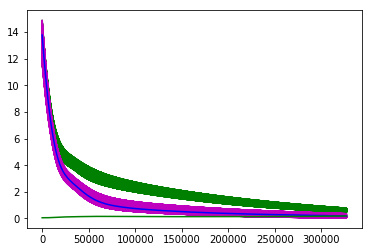

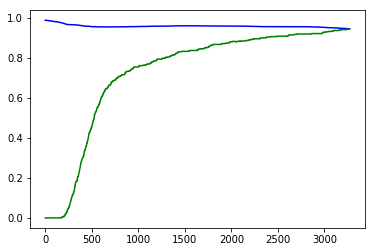

In [61]:
x = np.arange(0, len(cur_res['loss']), tuner.eval_frequency)
best_hparams_tuple = tuple([v for k, v in sorted(best_hparams.items())])
cur_res = tuner.results_list[t][best_hparams_tuple]
plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.plot(x, cur_res['val_loss'][0], color='g')
plt.show()
plt.plot(cur_res['val_acc'][0], color='b')
plt.plot(cur_res['val_acc'][1], color='g')
plt.show()


In [31]:
# task 2
t = 2
seed = 0
np.random.seed(0)
learning_rates = list(np.logspace(-5, -4, 4))
fisher_multipliers = [1000, 10000, 1e5]
dropout_input_probs = [1.0]
dropout_hidden_probs = [1.0]
prod = list(itertools.product(fisher_multipliers, dropout_input_probs, dropout_hidden_probs, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['fisher_multiplier'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[1]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['learning_rate'] = hparams_tuple[3]
    hparams.append(cur_dict)
tuner.hparams_list[t] = hparams

In [ ]:
best_avg, best_hparams = tuner.tune_on_task(t, BATCH_SIZE, verbose=True)

Training with dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=1000,learning_rate=1e-05,task=2
Restoring paramters from dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=10000,learning_rate=1e-06,task=1
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=10000,learning_rate=1e-06,task=1.ckpt-271800
validation accuracies: [0.95448923 0.9177489  0.        ], loss: 22.359528, loss with penalty: 22.359528
validation accuracies: [0.93519664 0.8939394  0.        ], loss: 13.189289, loss with penalty: 13.840592
validation accuracies: [0.9119466 0.8766234 0.       ], loss: 9.327451, loss with penalty: 10.925180
validation accuracies: [0.9013109  0.86796534 0.        ], loss: 7.000357, loss with penalty: 9.304497
validation accuracies: [0.8963641  0.85930735 0.        ], loss: 6.120909, loss with penalty: 8.810968
validation accuracies: [0.

In [18]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 32
print(tuner.validation_accuracy(t, VALIDATION_BATCH_SIZE))

INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/80_20_logs/fc50_fc10/checkpoints/dropout_hidden_prob=1.0,dropout_input_prob=1.0,fisher_multiplier=10000,learning_rate=1e-05,task=2.ckpt-48000
[0.9451884920634921, 0.8616071428571429, 0.65625]


In [19]:
tuner.save_results_list()
tuner.save_best_hparams()

cur_best_avg: 8.956354e-01, num_updates: 40600
best val_acc: [0.92208755 0.84632033 0.73333335]


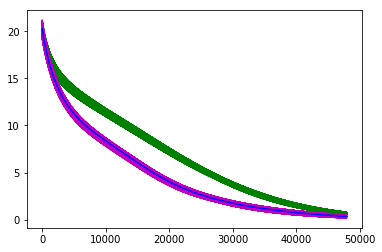

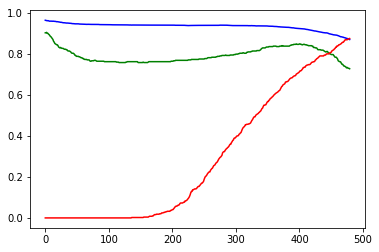

In [16]:
# print("best_avg: %e, best_params: %s" % (best_avg, str(best_params)))
# print("best_params: dropout: %f, fisher_multiplier: %e, lr: %e" % best_params)

# for k, v in tuner.results_list.items():
best_avg_tuple = tuple([v for k, v in sorted(tuner.best_hparams[t][0].items())])
cur_res = tuner.results_list[t][best_avg_tuple]
# cur_res = v
x = np.arange(0, len(cur_res['loss']), tuner.eval_frequency)
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, cur_best_avg_updates // tuner.eval_frequency])))
plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
plt.plot(cur_res['val_acc'][0], color='b')
plt.plot(cur_res['val_acc'][1], color='g')
plt.plot(cur_res['val_acc'][2], color='r')

plt.show()

In [17]:
def get_confusion_matrix(tuner):
    num_labels = 10
    pred = np.array([])
    actual = np.array([])
    for j in range(t + 1):
        val_data = tuner.task_list[j].validation
        feed_dict = tuner.classifier.create_feed_dict(val_data.images, val_data.labels, keep_input=1.0, keep_hidden=1.0)
        cur_scores, cur_y = tuner.classifier.get_predictions(sess, feed_dict)
        cur_pred = np.argmax(cur_scores, 1)
        cur_actual = np.argmax(cur_y, 1)
        actual = np.concatenate([actual, cur_actual])
        pred = np.concatenate([pred, cur_pred])
    confusion_matrix = np.zeros((num_labels,num_labels), dtype=np.int64)

    for i in range(actual.shape[0]):
        confusion_matrix[int(actual[i]), int(pred[i])] += 1
    return confusion_matrix

def print_confusion_matrix(confusion_matrix):
    print("%3d" % (0, ), end=' ')
    for j in range(confusion_matrix.shape[1]):
        print("%3d" % (j, ), end=' ')
    print("")
    for i in range(confusion_matrix.shape[0]):
        print("%3d" % (i, ), end=' ')
        for j in range(confusion_matrix.shape[1]):
            print("%3d" % (confusion_matrix[i][j], ), end= ' ')
        print("")

In [11]:
# confusion matrix before training
# train on best hyperparameters

# best_params = (1.0, 10 ** (18 / 19 + 4), 5e-6)
# best_num_updates = 3600

dropout, fisher_multiplier, lr = best_params
best_num_updates = result[best_params]['best_avg'][1]

model_name = tuner.file_name(lr, fisher_multiplier, t)
tuner.classifier.prepare_for_training(sess=tuner.sess, 
                                    model_name=model_name, 
                                    model_init_name=model_init_name, 
                                    fisher_multiplier=fisher_multiplier, 
                                    learning_rate=lr)

confusion_matrix = get_confusion_matrix(tuner)
print_confusion_matrix(confusion_matrix)


INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00077,multiplier=1291.96,mbsize=250,epochs=10,perm=0.ckpt-1759
  0   0   1   2   3   4   5   6   7   8   9 
  0 474   0   0   1   0   2   0   2   0   0 
  1   0 560   0   0   1   0   0   2   0   0 
  2   0   4 481   0   0   1   0   2   0   0 
  3   0   0   2 483   1   5   0   2   0   0 
  4   0   1   0   0 532   0   0   2   0   0 
  5   0   1   1   2   1 428   1   0   0   0 
  6   2   1   1   0   4   3 489   1   0   0 
  7   0   1   1   0   3   0   0 545   0   0 
  8   8  39  59 212  22 108   6   8   0   0 
  9   0   0   0   0   0   0   0   0   0   0 


In [10]:
# train on best hyperparameters
# dropout, fisher_multiplier, lr = best_params
dropout, fisher_multiplier, lr = (1.0, 10 ** (4 + 17 * 3 / 29), 5e-6)
best_num_updates = 1300
print("dropout: %f, fisher_multiplier: %e, lr: %e" % (dropout, fisher_multiplier, lr))
start_time = time.time()
model_name = tuner.file_name(lr, fisher_multiplier, t)
val_acc, val_loss, loss, loss_with_penalty, cur_best_avg, cur_best_avg_num_updates = train(lr, t, dropout_input, dropout, model_init_name, fisher_multiplier, best_num_updates)
# cur_params = (dropout, fisher_multiplier, lr)
# result[cur_params] = {}
# result[cur_params]["val_acc"] = val_acc
# result[cur_params]["val_loss"] = val_loss
# result[cur_params]["loss"] = loss
# result[cur_params]["loss_with_penalty"] = loss_with_penalty
# result[cur_params]["best_avg"] = (cur_best_avg, cur_best_avg_num_updates)
print("time taken: %f" % (time.time() - start_time))
print("loss with penalty: %f, loss: %f, val0 accuracy: %f, val1 accuracy: %f"
      % (loss_with_penalty[-1], loss[-1], 
         val_acc[0][cur_best_avg_num_updates // eval_frequency], val_acc[1][cur_best_avg_num_updates // eval_frequency]))

tuner.classifier.update_fisher_full_batch(sess, dataset_train)
tuner.classifier.save_weights(best_num_updates, tuner.sess, model_name)
tuner.best_parameters.append((lr, fisher_multiplier, model_name))

dropout: 1.000000, fisher_multiplier: 5.736153e+05, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00069,multiplier=1453.79,mbsize=250,epochs=10,perm=0.ckpt-1759
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00069,multiplier=1453.79,mbsize=250,epochs=10,perm=0.ckpt-1759
time taken: 36.348515
loss with penalty: 1.455915, loss: 0.449977, val0 accuracy: 0.973040, val1 accuracy: 0.900433
saving model layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1 at time step 1300


In [12]:
# task2
t = 2
dataset_train = tuner.task_list[t].train
dataset_lagged = tuner.task_list[t - 1].train if t > 0 else None
# model_init_name = tuner.best_parameters[t - 1][2] if t > 0 else None
model_init_name = 'layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1'
MINI_BATCH_SIZE = 256
LOG_FREQUENCY = 100
dataset_train.initialize_iterator(MINI_BATCH_SIZE)
if (dataset_lagged is not None):
    dataset_lagged.initialize_iterator(MINI_BATCH_SIZE)

eval_frequency = 100
dropout_input = 1.0
result_2 = {}

In [13]:
num_updates = 5000
# dropouts = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
dropouts = [1.0]
fisher_multipliers = np.logspace(2, 7, 50)
# fisher_multipliers = [0.0]
learning_rates = [5e-6]
best_avg = 0.0
best_params = -1
best_num_updates = -1
for dropout in dropouts:
    for fisher_multiplier in fisher_multipliers:
        for lr in learning_rates:
            print("dropout: %f, fisher_multiplier: %e, lr: %e" % (dropout, fisher_multiplier, lr))
            start_time = time.time()
            val_acc, val_loss, loss, loss_with_penalty, cur_best_avg, cur_best_avg_num_updates = train(lr, t, dropout_input, dropout, model_init_name, fisher_multiplier)
        cur_params = (dropout, fisher_multiplier, lr)
        result_2[cur_params] = {}
        result_2[cur_params]["val_acc"] = val_acc
        result_2[cur_params]["val_loss"] = val_loss
        result_2[cur_params]["loss"] = loss
        result_2[cur_params]["loss_with_penalty"] = loss_with_penalty
        result_2[cur_params]["best_avg"] = (cur_best_avg, cur_best_avg_num_updates)
        if (best_avg < cur_best_avg):
            best_avg = cur_best_avg
            best_params = cur_params
            best_num_updates = cur_best_avg_num_updates
        print("time taken: %f" % (time.time() - start_time))
        print("loss with penalty: %f, loss: %f, val0 accuracy: %f, val1 accuracy: %f, val2 accuracy: %f"
              % (loss_with_penalty[-1], loss[-1], 
                 val_acc[0][cur_best_avg_num_updates // eval_frequency], val_acc[1][cur_best_avg_num_updates // eval_frequency], val_acc[2][cur_best_avg_num_updates // eval_frequency]))

dropout: 1.000000, fisher_multiplier: 1.000000e+02, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 23.703945
loss with penalty: 0.165240, loss: 0.079856, val0 accuracy: 0.968835, val1 accuracy: 0.478355, val2 accuracy: 0.735354
dropout: 1.000000, fisher_multiplier: 1.264855e+02, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 24.908948
loss with penalty: 0.162454, loss: 0.059935, val0 accuracy: 0.968835, val1 accuracy: 0.480519, val2 accuracy: 0.735354
dropout: 1.000000, fisher_multiplier: 1.599859e+02, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoint

INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 50.275783
loss with penalty: 1.477962, loss: 0.341894, val0 accuracy: 0.961167, val1 accuracy: 0.803030, val2 accuracy: 0.901010
dropout: 1.000000, fisher_multiplier: 1.389495e+04, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 46.886580
loss with penalty: 1.645556, loss: 0.360029, val0 accuracy: 0.962899, val1 accuracy: 0.829004, val2 accuracy: 0.876768
dropout: 1.000000, fisher_multiplier: 1.757511e+04, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epoc

INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 20.514503
loss with penalty: 13.439526, loss: 12.901023, val0 accuracy: 0.972050, val1 accuracy: 0.915584, val2 accuracy: 0.000000
dropout: 1.000000, fisher_multiplier: 1.526418e+06, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 20.267411
loss with penalty: 14.109320, loss: 13.665174, val0 accuracy: 0.972050, val1 accuracy: 0.915584, val2 accuracy: 0.000000
dropout: 1.000000, fisher_multiplier: 1.930698e+06, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,

In [15]:
# train on best hyperparameters
dropout, fisher_multiplier, lr = best_params
# dropout, fisher_multiplier, lr = (1.0, 10 ** (4 + 17 * 3 / 29), 5e-6)
# best_num_updates = 1300
print("dropout: %f, fisher_multiplier: %e, lr: %e" % (dropout, fisher_multiplier, lr))
start_time = time.time()
model_name = tuner.file_name(lr, fisher_multiplier, t)
val_acc, val_loss, loss, loss_with_penalty, cur_best_avg, cur_best_avg_num_updates = train(lr, t, dropout_input, dropout, model_init_name, fisher_multiplier, best_num_updates)
# cur_params = (dropout, fisher_multiplier, lr)
# result[cur_params] = {}
# result[cur_params]["val_acc"] = val_acc
# result[cur_params]["val_loss"] = val_loss
# result[cur_params]["loss"] = loss
# result[cur_params]["loss_with_penalty"] = loss_with_penalty
# result[cur_params]["best_avg"] = (cur_best_avg, cur_best_avg_num_updates)
print("time taken: %f" % (time.time() - start_time))
print("loss with penalty: %f, loss: %f, val0 accuracy: %f, val1 accuracy: %f, val2 accuracy: %f"
      % (loss_with_penalty[-1], loss[-1], 
         val_acc[0][cur_best_avg_num_updates // eval_frequency], val_acc[1][cur_best_avg_num_updates // eval_frequency], val_acc[2][cur_best_avg_num_updates // eval_frequency]))

tuner.classifier.update_fisher_full_batch(sess, dataset_train)
tuner.classifier.save_weights(best_num_updates, tuner.sess, model_name)
tuner.best_parameters.append((lr, fisher_multiplier, model_name))

dropout: 1.000000, fisher_multiplier: 1.757511e+04, lr: 5.000000e-06
INFO:tensorflow:Restoring parameters from gs://continual_learning/permMNIST_EWC/unequal_split_logs/checkpoints/layers=2,hidden=500,lr=0.00001,multiplier=573615.25,mbsize=250,epochs=10,perm=1.ckpt-1300
time taken: 32.221372
loss with penalty: 2.306470, loss: 0.514236, val0 accuracy: 0.968835, val1 accuracy: 0.833333, val2 accuracy: 0.826263
saving model layers=2,hidden=500,lr=0.00001,multiplier=17575.11,mbsize=250,epochs=10,perm=2 at time step 1900


In [18]:
# confusion matrix 
# finding which digits are being confused by classifier
confusion_matrix = get_confusion_matrix(tuner)
print_confusion_matrix(confusion_matrix)

  0   0   1   2   3   4   5   6   7   8   9 
  0 476   0   0   0   0   0   0   0   2   1 
  1   0 552   2   1   0   0   0   1   7   0 
  2   2   3 477   0   0   0   0   1   4   1 
  3   0   1   6 469   0   4   0   2   9   2 
  4   0   1   4   0 508   1   2   2   2  15 
  5   0   2   1   1   0 421   4   0   2   3 
  6   6   1   0   0   0   2 487   0   4   1 
  7   1   0   4   0   0   0   0 526   3  16 
  8   4   7  16  19   0  20   3   0 388   5 
  9   6   2   0   7  32   5   1  20   9 413 


In [19]:
# test accuracy
for j in range(t + 1):
    test_data = tuner.task_list[j].test
    feed_dict = tuner.classifier.create_feed_dict(test_data.images, test_data.labels, keep_input=1.0, keep_hidden=1.0)
    accuracy = sess.run([tuner.classifier.loss, tuner.classifier.accuracy], feed_dict=feed_dict)
    print(accuracy)

[0.12978701, 0.9642011]
[0.53868216, 0.8110883]
[0.5814527, 0.82160556]


In [20]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()